In [1]:
%%capture
# Install HermesPy and its dependencies in the current kernel
# When running on Colabs, a restart of the runtime is required afterwards

import sys
!{sys.executable} -m pip install --quiet hermespy[audio]

Using Audio Equipment
=====================

This notebook will outline how to setup hardaware validation loops transmitting communication waveforms over sound cards.

More precisely, we will initially set up a SISO link transmitting over the first output channel and receiving over the first input channel of a sound card, respectively.
For generating this notebook's content, the channels have been diretly linked by a patch cable.

Initially, we will import all required modules:

In [2]:
import matplotlib.pyplot as plt

from hermespy.hardware_loop.audio import AudioDevice
from hermespy.modem import DuplexModem, RootRaisedCosineWaveform, SingleCarrierCorrelationSynchronization, SingleCarrierZeroForcingChannelEqualization, SingleCarrierLeastSquaresChannelEstimation

The link can be configured by assigning the proper audio device and channel indices.
The device indices are native to the host system, so when executing this notebook lokally, the indices for transmitting $(6)$ and receiving $(4)$ device will differ.
They may be queried by calling the function [query_devices](https://python-sounddevice.readthedocs.io/en/0.4.4/api/checking-hardware.html#sounddevice.query_devices) of the underyling sounddevice package.

In [3]:
device = AudioDevice(6, 4, [1], [1],  max_receive_delay=1)

The device will be operated by a communication modem transmitting a single-carrier waveform at at symbol rate of $10~\mathrm{kHz}$ filtered by a root-raised-cosine pulse impulse response.

In [4]:
modem = DuplexModem(seed=42)
device.add_dsp(modem)

waveform = RootRaisedCosineWaveform(symbol_rate=1e4, pilot_rate=64, num_preamble_symbols=128,
                                    num_data_symbols=2048, oversampling_factor=8, modulation_order=4)
waveform.synchronization = SingleCarrierCorrelationSynchronization()
waveform.channel_estimation = SingleCarrierLeastSquaresChannelEstimation()
waveform.channel_equalization = SingleCarrierZeroForcingChannelEqualization()
modem.waveform = waveform

Note that the audio device will internally apply a [Hilbert](https://en.wikipedia.org/wiki/Hilbert_transform) transformation to convert the complex-valued communication waveforms to real-valued envelopes to be transmitted over the audio channels.
This requires at least an oversampling factor of two, ideally higher.

We may now generate and visualize the information of a single communication frame to be transmitted over the device output channel:

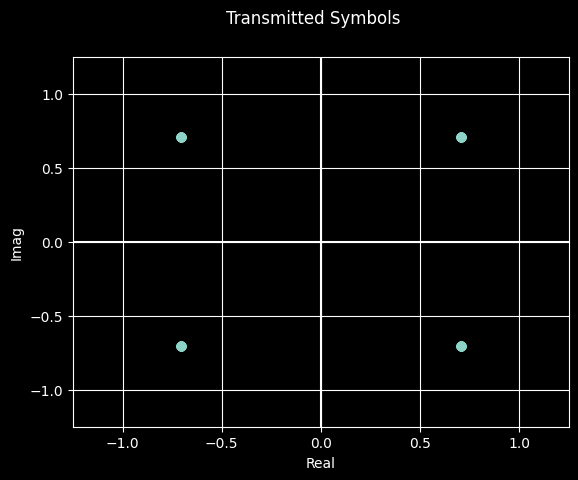

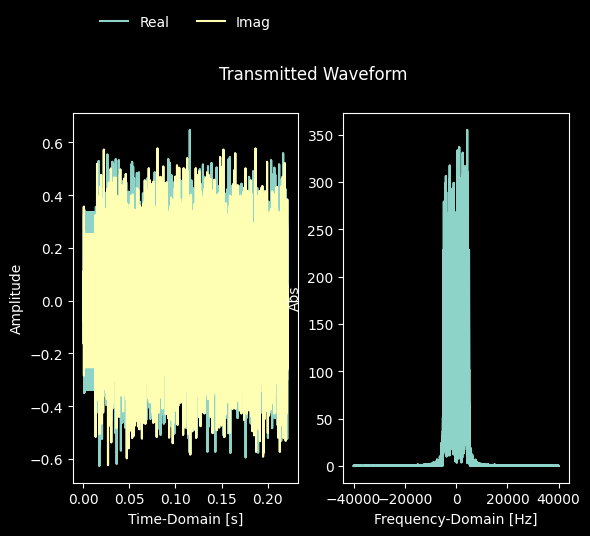

In [5]:
transmission = modem.transmit(device.state())
_ = transmission.symbols.plot_constellation(title='Transmitted Symbols')
_ = transmission.signal.plot(title='Transmitted Waveform')
plt.show()

This waveform can be transmitted and received over the device by calling the hardware-loop specific configure, trigger and fetch routines.

**Warning: If you are running this section for the first time, especially over speakers, turn down the volume!**

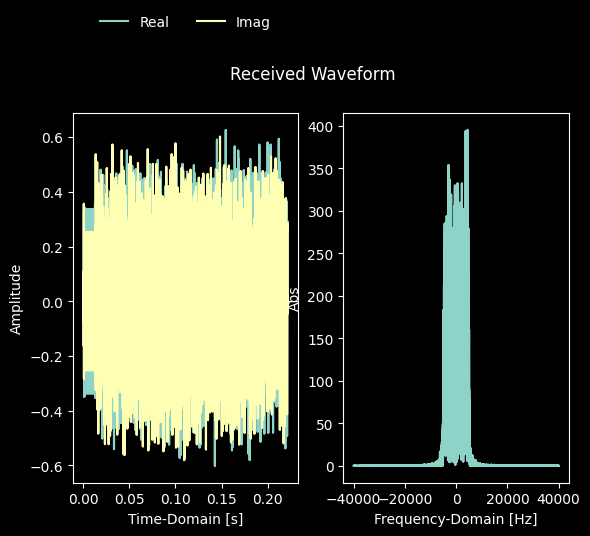

In [6]:
# Trigger device transmission
device.transmit()
device.trigger()
reception = device.receive()

_ = reception.impinging_signals[0].plot(title='Received Waveform')
plt.show()

As expected, we received a signal frame clearly visible in the time-domain.
We can now inspect the proper synchronization by plotting only the signal portion of the detected frame:

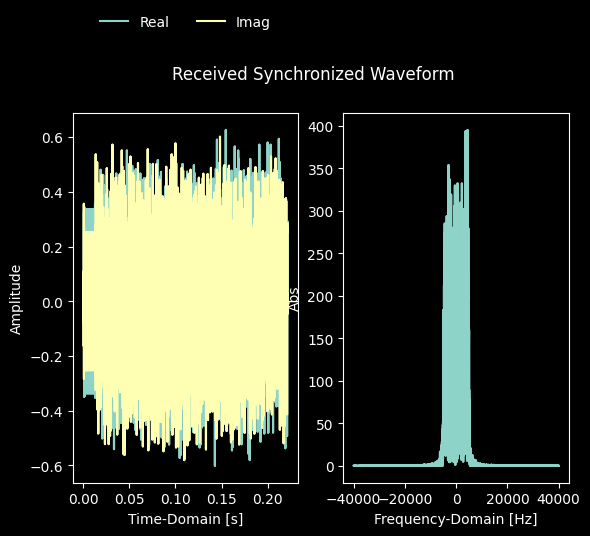

In [7]:
_ = reception.operator_receptions[0].frames[0].signal.plot(title='Received Synchronized Waveform')
plt.show()

Proper demodulation and equlization can be assessed by plotting the received symbol constellation and evaluating the bit error rate of the transmitted frame:

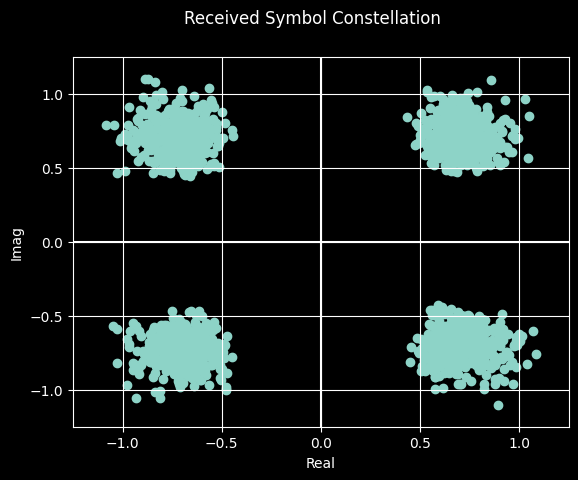

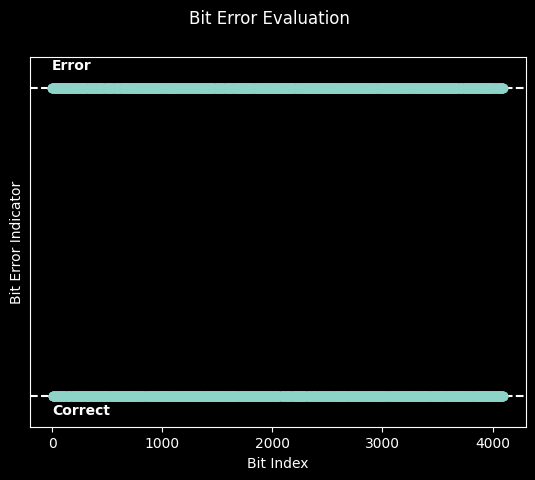

In [8]:
from hermespy.modem import BitErrorEvaluator

_ = reception.operator_receptions[0].frames[0].equalized_symbols.plot_constellation(title='Received Symbol Constellation')

ber = BitErrorEvaluator(modem, modem)
device.transmit()
device.receive()
_ = ber.evaluate().visualize()
plt.show()